In [ ]:
# load required libraries
# load required libraries
import os
import librosa
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.image import resize
from tensorflow.keras.models import load_model
# import wandb

In [ ]:
from google.colab import drive
import sys

#wandb.login()

drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/ucph')


Mounted at /content/drive


In [ ]:
def get_person(filename):
  splits = filename.split("_")
  if splits[0] == "ronja":
    return "ronja"
  else:
    return splits[1]

def get_shot(filename):
  splits = filename.split("_")
  if splits[1] == "smash":
    return "smash"
  else:
    return splits[0]

def convert_label(df):
  lab2id = {"clear": 0, "slice": 1, "smash": 2}
  # df['label'] = df['shot'].map(lab2id) this did not word as intended
  def map_label(shot):
        return lab2id.get(shot, -1)  # return -1 if shot is not in lab2id

  # Apply the map_label function to each element of the 'shot' column
  df['label'] = df['shot'].apply(map_label)
  return df

def add_mel_spectrogram(df):
  def create_mel_spectrogram(audio_array):
    audio_array = np.array(audio_array)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_array)
    return np.array(mel_spectrogram)

  df["audio"] = df["audio"].apply(create_mel_spectrogram)
  return df

def prepare_and_load_dataset():
  path = '/content/drive/MyDrive/ucph/CCS2/data/'
  column_names = ["filename", "shot", "pose", "audio", "mel_spectrogram", "start_point", "end_point"]
  # read csv and convert label
  train_df = pd.read_json(f'{path}train_0.json')
  test_df = pd.read_json(f'{path}test_0.json')

  for i in range(1, 10):
    data = pd.read_json(f'{path}train_{i}.json')
    train_df = pd.concat([train_df, data], ignore_index=True)
    data = pd.read_json(f'{path}test_{i}.json')
    test_df = pd.concat([test_df, data], ignore_index=True)

  # reset index
  train_df.reset_index(drop=True, inplace=True)
  test_df.reset_index(drop=True, inplace=True)

  # shuffle datasets
  train_df = train_df.sample(frac=1, random_state=42)
  test_df = test_df.sample(frac=1, random_state=42)

  # convert string lables to int
  train_df = convert_label(train_df)
  test_df = convert_label(test_df)

  # create mel_spectrograms
  train_df = add_mel_spectrogram(train_df)
  test_df = add_mel_spectrogram(test_df)

  # create pose arrays
  def create_pose_array(pose_array):
    try:
      pose_array = np.array(pose_array)
      if pose_array.shape == (62, 33, 4):
        # pose_array = np.reshape(pose_array, (62, -1))
        # mean = np.mean(pose_array, axis=0)
        # std = np.mean(pose_array, axis=0)
        #mean_first_last = np.mean(pose_array, axis=(0, 2))
        #std_first_last = np.std(pose_array, axis=(0, 2))

        # Broadcast mean and standard deviation arrays to match the shape of array_3d
        #mean_broadcasted = np.broadcast_to(mean_first_last[:, np.newaxis, :], pose_array.shape)
        #std_broadcasted = np.broadcast_to(std_first_last[:, np.newaxis, :], pose_array.shape)

        # Subtract means and divide through standard deviations
        #pose_array = (pose_array - mean_broadcasted) / std_broadcasted
        #pose_array = (pose_array - mean) / std
        return pose_array
      else:
        return np.nan
    except:
      return np.nan

  train_df['pose'] = train_df['pose'].apply(create_pose_array)
  train_df = train_df.dropna(subset=['pose'])
  test_df['pose'] = test_df['pose'].apply(create_pose_array)
  test_df = test_df.dropna(subset=['pose'])

  # create comb array
  def create_comb(row):
    pose_array = row['pose'].reshape(62, -1)
    mel_spec = row['audio']
    if pose_array.shape == (62, 33*4) and mel_spec.shape == (128, 176):
      zeros_array = np.zeros((128, 33*4))
      for i in range(62):
        zeros_array[(i*2)+1] = pose_array[i] # every second row for the pose part is empty
      combined = np.concatenate((zeros_array, mel_spec), axis=1)
      assert combined.shape == (128, 176 + 33*4)
      return combined

  train_df["comb"] = train_df.apply(create_comb, axis=1)
  test_df["comb"] = test_df.apply(create_comb, axis=1)

  test_df['name'] = test_df['filename'].apply(get_person)
  test_df['shot'] = test_df['filename'].apply(get_shot)

  return train_df, test_df

def get_model_input_data(test_df, column_name):
  # extract data and labels
  x_test = test_df[column_name].values
  x_test = np.stack(x_test)
  y_test = test_df["label"].values
  return x_test, y_test

train_df, test_df = prepare_and_load_dataset()
x_test, y_test = get_model_input_data(test_df, 'comb')

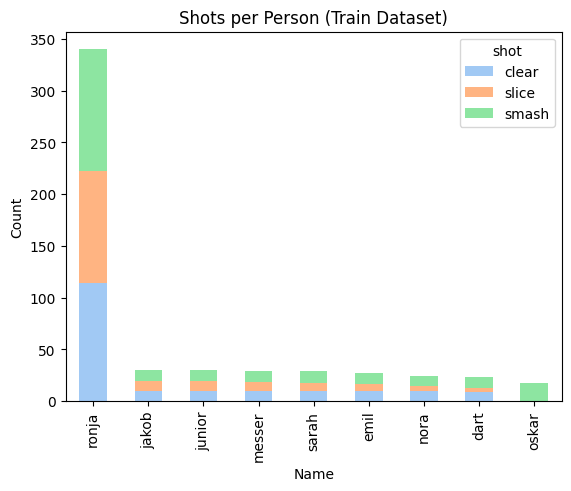

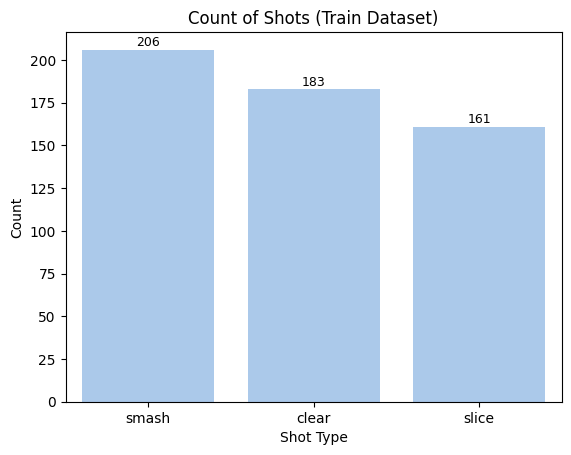

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


train = pd.DataFrame()
train['name'] = train_df['filename'].apply(get_person)
train['shot'] = train_df['filename'].apply(get_shot)

# Count of shots for each person and each type of shot
train_counts = train.groupby(['name', 'shot']).size().unstack().fillna(0)

# Order the histogram by the count of shots
train_counts['total'] = train_counts.sum(axis=1)
train_counts = train_counts.sort_values(by='total', ascending=False).drop(columns='total')

# Plot using Seaborn with pastel theme for the first plot
sns.set_palette("pastel")
ax = train_counts.plot(kind='bar', stacked=True)

plt.xlabel('Name')
plt.ylabel('Count')
plt.title('Shots per Person (Train Dataset)')
plt.show()

# Count of shots for each type of shot
shot_counts = train['shot'].value_counts()

# Plot using Seaborn with pastel theme
sns.set_palette("pastel")
ax = sns.barplot(x=shot_counts.index, y=shot_counts.values)

# Add count labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=9, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.xlabel('Shot Type')
plt.ylabel('Count')
plt.title('Count of Shots (Train Dataset)')
plt.show()
print(train_counts)

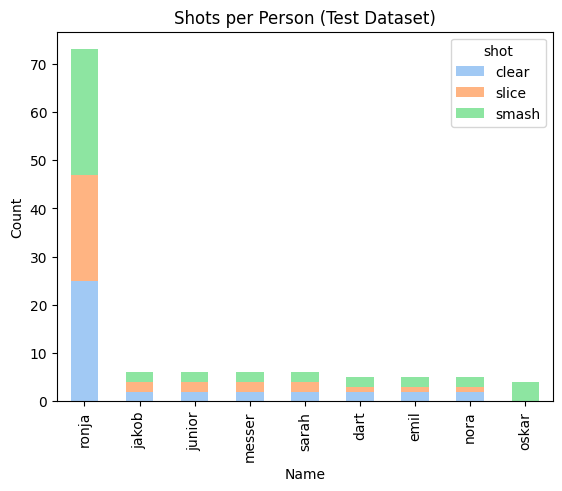

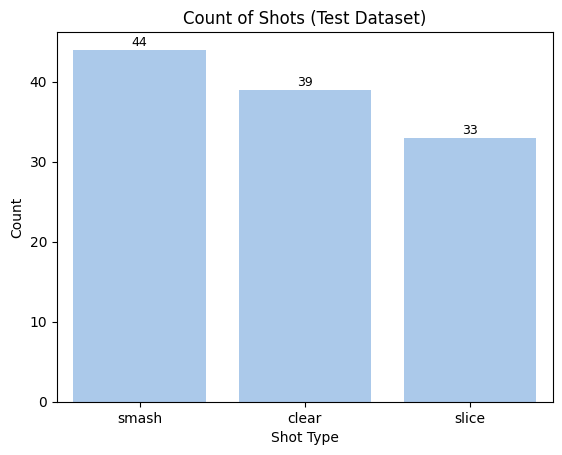

In [ ]:
test = pd.DataFrame()
test['name'] = test_df['filename'].apply(get_person)
test['shot'] = test_df['filename'].apply(get_shot)

# Count of shots for each person and each type of shot
test_counts = test.groupby(['name', 'shot']).size().unstack().fillna(0)

# Order the histogram by the count of shots
test_counts['total'] = test_counts.sum(axis=1)
test_counts = test_counts.sort_values(by='total', ascending=False).drop(columns='total')

# Plot using Seaborn with pastel theme for the first plot
sns.set_palette("pastel")
ax = test_counts.plot(kind='bar', stacked=True)

plt.xlabel('Name')
plt.ylabel('Count')
plt.title('Shots per Person (Test Dataset)')
plt.show()

# Count of shots for each type of shot
shot_counts = test['shot'].value_counts()

# Plot using Seaborn with pastel theme
sns.set_palette("pastel")
ax = sns.barplot(x=shot_counts.index, y=shot_counts.values)

# Add count labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=9, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.xlabel('Shot Type')
plt.ylabel('Count')
plt.title('Count of Shots (Test Dataset)')
plt.show()

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
from tensorflow.keras.models import load_model

# Define your class labels
classes = ['clear', 'slice', 'smash']

# Function to preprocess and classify one sample
def test_sample(sample, model):

    # Make predictions
    sample = sample.reshape(1, *sample.shape)
    predictions = model.predict(sample)

    # Get the class probabilities
    class_probabilities = predictions[0]

    # Get the predicted class index
    predicted_class_index = np.argmax(class_probabilities)
    return class_probabilities, predicted_class_index

# test the best model for audio, pose and comb for test data
def test_model(model_file_name, X_test, y_test, name):

  # Load the saved model
  model = load_model(f'/content/drive/MyDrive/ucph/CCS2/models/{model_file_name}.keras')

  predictions = []
  predictions_per_class = []

  # Test an audio file
  for index in range(X_test.shape[0]):
    class_probabilities, predicted_class_index = test_sample(X_test[index], model)
    predictions.append(predicted_class_index)
    predictions_per_class.append(class_probabilities)

  y_test_cat = to_categorical(y_test, num_classes=3)  # Convert labels to one-hot encoding

  macro_f1 = f1_score(y_test, predictions, average='macro')

  # Calculate accuracy for each individual class
  class_accuracies = []
  for i in range(len(classes)):
      class_accuracy = accuracy_score(y_test == i, np.array(predictions) == i)
      class_accuracies.append(class_accuracy)

  # Calculate overall accuracy
  overall_accuracy = accuracy_score(y_test, predictions)

  # convert predictions to other data types
  predictions = np.array(predictions)
  predictions_per_class = np.stack(predictions_per_class)

  # calculate mean abs error
  mean_abs_error = np.sum(np.abs(np.where(y_test-predictions != 0, 1, 0))) / y_test.shape[0]

  # calculate rel error
  a = np.sum(np.multiply(y_test_cat, predictions_per_class), axis=1)
  b = np.where(y_test-predictions != 0, 1, 0)
  rel_error = np.sum(np.multiply(a, b))

  # print all the results
  print("-------------------------------------------------------------------------")
  print(name)
  print(f"Macro F1 score: {macro_f1}")
  print("Accuracy for each individual class:")
  for i, accuracy in enumerate(class_accuracies):
      print(f"Class {classes[i]}: {accuracy}")
  print(f"Overall accuracy: {overall_accuracy}")
  print(f"Mean Absolute Error: {mean_abs_error}")
  print(f"Relative Error: {rel_error}")


In [ ]:
players = test_df['name'].unique()

# Iterate over unique values
for name in players:
    # Filter dataframe for each unique value
    df = test_df[test_df['name'] == name]
    print(f"-----------------{name}------------------")
    x_test, y_test = get_model_input_data(df, 'comb')
    print(x_test.shape, y_test.shape)
    test_model('comb_classification_model_2', x_test, y_test, name)


-----------------ronja------------------
(73, 128, 308) (73,)
1/1 [==============================] - 0s 43ms/step
-------------------------------------------------------------------------
ronja
Macro F1 score: 0.7140277777777778
Accuracy for each individual class:
Class clear: 0.9726027397260274
Class slice: 0.9863013698630136
Class smash: 0.9452054794520548
Overall accuracy: 0.9315068493150684
Mean Absolute Error: 0.0684931506849315
Relative Error: 3.4225984811782837
-----------------dart------------------
(5, 128, 308) (5,)
1/1 [==============================] - 0s 25ms/step
-------------------------------------------------------------------------
dart
Macro F1 score: 1.0
Accuracy for each individual class:
Class clear: 1.0
Class slice: 1.0
Class smash: 1.0
Overall accuracy: 1.0
Mean Absolute Error: 0.0
Relative Error: 0.0
-----------------messer------------------
(6, 128, 308) (6,)
1/1 [==============================] - 0s 27ms/step
--------------------------------------------------

In [ ]:
# Load the saved model
# audio_model = load_model(f'/content/drive/MyDrive/ucph/CCS2/models/audio_classification_model_2.keras')
# pose_model = load_model(f'/content/drive/MyDrive/ucph/CCS2/models/pose_classification_model_1.keras')
# ensemble_model = load_model(f'/content/drive/MyDrive/ucph/CCS2/models/ensemble_classification_model_0.keras')
# comb_model = load_model(f'/content/drive/MyDrive/ucph/CCS2/models/comb_classification_model_2.keras')
